In [1]:
!pip install torch torchvision imageio opencv-python-headless tifffile imagecodecs #installing all the required libraries

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 MB 4.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 4.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 4.2 MB/s eta 0:00:0000:0100:01


In [2]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Update the paths to point to the dataset directories
flori21_image_dir = os.path.join(current_dir, 'FLoRI21_DataPort_Extracted')
fire_image_dir = os.path.join(current_dir, 'FIRE_Extracted/Images')

# Print the paths to verify
print("FLoRI21 Image Directory:", flori21_image_dir)
print("FIRE Image Directory:", fire_image_dir)

FLoRI21 Image Directory: /Users/aryanmhalsank/Desktop/Retinal Classification/FLoRI21_DataPort_Extracted
FIRE Image Directory: /Users/aryanmhalsank/Desktop/Retinal Classification/FIRE_Extracted/Images


In [5]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Dataset Class for images (FLoRI21 and FIRE Dataset)
class RetinalImageDataset(Dataset):
    def __init__(self, image_dir, transform=None, image_exts=['.tif', '.png', '.jpeg', '.jpg']):
        self.image_dir = image_dir
        self.image_files = []
        for root, _, files in os.walk(image_dir):
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_exts):
                    self.image_files.append(os.path.join(root, file))
        self.transform = transform
        print(f"Found {len(self.image_files)} images in {self.image_dir}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        try:
            image = Image.open(img_path).convert("L")  # Open image in grayscale
        except FileNotFoundError:
            print(f"File not found: {img_path}")
            return None  # Handle missing files accordingly
        
        if self.transform:
            image = self.transform(image)
        return image

# Dataset Class for EyePACS (images only)
class EyePACSDataset(Dataset):
    def __init__(self, image_dir, transform=None, image_exts=['.ppm']):
        self.image_dir = image_dir
        self.image_files = []
        for root, _, files in os.walk(image_dir):
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_exts):
                    self.image_files.append(os.path.join(root, file))
        self.transform = transform
        print(f"Found {len(self.image_files)} images in {self.image_dir}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        try:
            image = Image.open(img_path).convert("L")  # Open image in grayscale
        except FileNotFoundError:
            print(f"File not found: {img_path}")
            return None  # Handle missing files accordingly
        
        if self.transform:
            image = self.transform(image)
        return image

# Data augmentation and transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor()
])

# Define the paths for all datasets
flori21_image_dir = 'FLoRI21_DataPort/'
fire_image_dir = 'FIRE/Images'
eyepacs_image_dir = 'EyePACS/'  # No labels file needed for EyePACS

# Load datasets
flori21_dataset = RetinalImageDataset(image_dir=flori21_image_dir, transform=transform)
fire_dataset = RetinalImageDataset(image_dir=fire_image_dir, transform=transform)
eyepacs_dataset = EyePACSDataset(image_dir=eyepacs_image_dir, transform=transform)

# Create data loaders
flori21_dataloader = DataLoader(flori21_dataset, batch_size=4, shuffle=True)
fire_dataloader = DataLoader(fire_dataset, batch_size=4, shuffle=True)
eyepacs_dataloader = DataLoader(eyepacs_dataset, batch_size=4, shuffle=True)

# Define the Neural Network Model
class RetinalImageModel(nn.Module):
    def __init__(self):
        super(RetinalImageModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Set up device for Apple Silicon MPS
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Set up model, loss function, optimizer, and scheduler
model = RetinalImageModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training function with model saving functionality
def train_model(dataloader, model, criterion, optimizer, scheduler, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        
        for batch in dataloader:
            batch = [img for img in batch if img is not None]
            if len(batch) == 0:  # If all images in this batch were missing, skip this batch
                continue

            images = torch.stack(batch).to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, images)  # For unsupervised reconstruction tasks
            
            loss.backward()
            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")
    
    # Save model checkpoint after training
    model_save_path = 'retinal_image_model.pkl'
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

# Training on each dataset
num_epochs = 40

print("\nTraining on FLoRI21 dataset:")
train_model(flori21_dataloader, model, criterion, optimizer, scheduler, num_epochs)

print("\nTraining on FIRE dataset:")
train_model(fire_dataloader, model, criterion, optimizer, scheduler, num_epochs)

print("\nTraining on EyePACS dataset:")
train_model(eyepacs_dataloader, model, criterion, optimizer, scheduler, num_epochs)


Found 20 images in FLoRI21_DataPort/
Found 268 images in FIRE/Images
Found 397 images in EyePACS/
Using MPS (Apple Silicon GPU)

Training on FLoRI21 dataset:
Epoch [1/40], Loss: 0.1072
Epoch [2/40], Loss: 0.0786
Epoch [3/40], Loss: 0.0753
Epoch [4/40], Loss: 0.0740
Epoch [5/40], Loss: 0.0744
Epoch [6/40], Loss: 0.0750
Epoch [7/40], Loss: 0.0727
Epoch [8/40], Loss: 0.0731
Epoch [9/40], Loss: 0.0760
Epoch [10/40], Loss: 0.0737
Epoch [11/40], Loss: 0.0753
Epoch [12/40], Loss: 0.0740
Epoch [13/40], Loss: 0.0747
Epoch [14/40], Loss: 0.0749
Epoch [15/40], Loss: 0.0744
Epoch [16/40], Loss: 0.0744
Epoch [17/40], Loss: 0.0738
Epoch [18/40], Loss: 0.0745
Epoch [19/40], Loss: 0.0743
Epoch [20/40], Loss: 0.0741
Epoch [21/40], Loss: 0.0755
Epoch [22/40], Loss: 0.0732
Epoch [23/40], Loss: 0.0736
Epoch [24/40], Loss: 0.0741
Epoch [25/40], Loss: 0.0734
Epoch [26/40], Loss: 0.0756
Epoch [27/40], Loss: 0.0735
Epoch [28/40], Loss: 0.0748
Epoch [29/40], Loss: 0.0748
Epoch [30/40], Loss: 0.0747
Epoch [31/4

Found 20 images in FLoRI21_DataPort/
Found 268 images in FIRE/Images
Found 397 images in EyePACS/
Using MPS (Apple Silicon GPU)

Training on FLoRI21 dataset:
Epoch [1/40], Loss: 0.2375
Epoch [2/40], Loss: 0.1997
Epoch [3/40], Loss: 0.1903
Epoch [4/40], Loss: 0.1920
Epoch [5/40], Loss: 0.1906
Epoch [6/40], Loss: 0.1920
Epoch [7/40], Loss: 0.1912
Epoch [8/40], Loss: 0.1928
Epoch [9/40], Loss: 0.1909
Epoch [10/40], Loss: 0.1935
Epoch [11/40], Loss: 0.1912
Epoch [12/40], Loss: 0.1933
Epoch [13/40], Loss: 0.1924
Epoch [14/40], Loss: 0.1928
Epoch [15/40], Loss: 0.1927
Epoch [16/40], Loss: 0.1920
Epoch [17/40], Loss: 0.1934
Epoch [18/40], Loss: 0.1922
Epoch [19/40], Loss: 0.1886
Epoch [20/40], Loss: 0.1915
Epoch [21/40], Loss: 0.1905
Epoch [22/40], Loss: 0.1899
Epoch [23/40], Loss: 0.1899
Epoch [24/40], Loss: 0.1888
Epoch [25/40], Loss: 0.1915
Epoch [26/40], Loss: 0.1905
Epoch [27/40], Loss: 0.1920
Epoch [28/40], Loss: 0.1913
Epoch [29/40], Loss: 0.1897
Epoch [30/40], Loss: 0.1913
Epoch [31/4

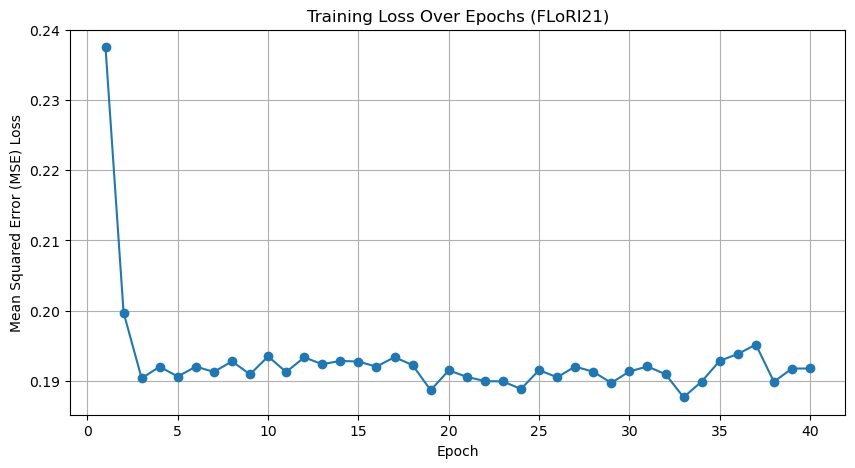


Training on FIRE dataset:
Epoch [1/40], Loss: 0.1327
Epoch [2/40], Loss: 0.1328
Epoch [3/40], Loss: 0.1332
Epoch [4/40], Loss: 0.1334
Epoch [5/40], Loss: 0.1329
Epoch [6/40], Loss: 0.1330
Epoch [7/40], Loss: 0.1337
Epoch [8/40], Loss: 0.1342
Epoch [9/40], Loss: 0.1331
Epoch [10/40], Loss: 0.1328
Epoch [11/40], Loss: 0.1332
Epoch [12/40], Loss: 0.1337
Epoch [13/40], Loss: 0.1342
Epoch [14/40], Loss: 0.1328
Epoch [15/40], Loss: 0.1338
Epoch [16/40], Loss: 0.1336
Epoch [17/40], Loss: 0.1349
Epoch [18/40], Loss: 0.1336
Epoch [19/40], Loss: 0.1331
Epoch [20/40], Loss: 0.1335
Epoch [21/40], Loss: 0.1336
Epoch [22/40], Loss: 0.1335
Epoch [23/40], Loss: 0.1329
Epoch [24/40], Loss: 0.1343
Epoch [25/40], Loss: 0.1337
Epoch [26/40], Loss: 0.1337
Epoch [27/40], Loss: 0.1335
Epoch [28/40], Loss: 0.1333
Epoch [29/40], Loss: 0.1330
Epoch [30/40], Loss: 0.1344
Epoch [31/40], Loss: 0.1337
Epoch [32/40], Loss: 0.1329
Epoch [33/40], Loss: 0.1344
Epoch [34/40], Loss: 0.1333
Epoch [35/40], Loss: 0.1341
Ep

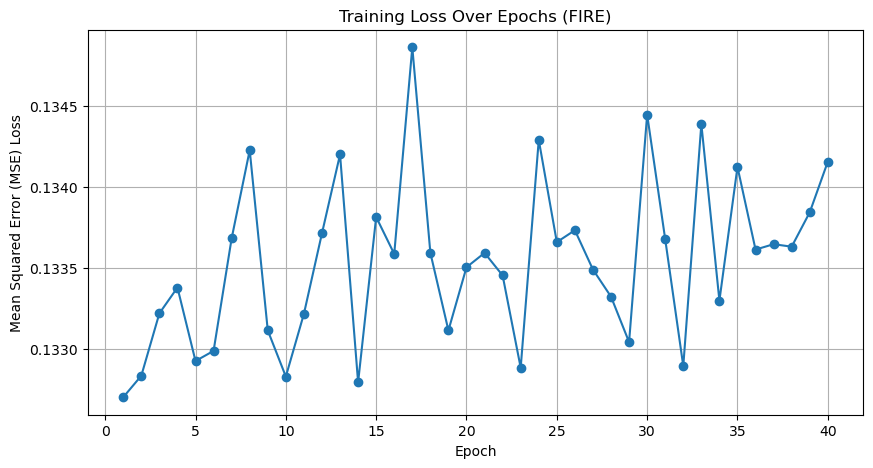


Training on EyePACS dataset:
Epoch [1/40], Loss: 0.1132
Epoch [2/40], Loss: 0.1134
Epoch [3/40], Loss: 0.1137
Epoch [4/40], Loss: 0.1143
Epoch [5/40], Loss: 0.1137
Epoch [6/40], Loss: 0.1137
Epoch [7/40], Loss: 0.1140
Epoch [8/40], Loss: 0.1139
Epoch [9/40], Loss: 0.1139
Epoch [10/40], Loss: 0.1139
Epoch [11/40], Loss: 0.1140
Epoch [12/40], Loss: 0.1144
Epoch [13/40], Loss: 0.1136
Epoch [14/40], Loss: 0.1136
Epoch [15/40], Loss: 0.1138
Epoch [16/40], Loss: 0.1140
Epoch [17/40], Loss: 0.1138
Epoch [18/40], Loss: 0.1141
Epoch [19/40], Loss: 0.1136
Epoch [20/40], Loss: 0.1136
Epoch [21/40], Loss: 0.1143
Epoch [22/40], Loss: 0.1146
Epoch [23/40], Loss: 0.1138
Epoch [24/40], Loss: 0.1141
Epoch [25/40], Loss: 0.1132
Epoch [26/40], Loss: 0.1141
Epoch [27/40], Loss: 0.1138
Epoch [28/40], Loss: 0.1133
Epoch [29/40], Loss: 0.1143
Epoch [30/40], Loss: 0.1136
Epoch [31/40], Loss: 0.1143
Epoch [32/40], Loss: 0.1143
Epoch [33/40], Loss: 0.1137
Epoch [34/40], Loss: 0.1141
Epoch [35/40], Loss: 0.1134

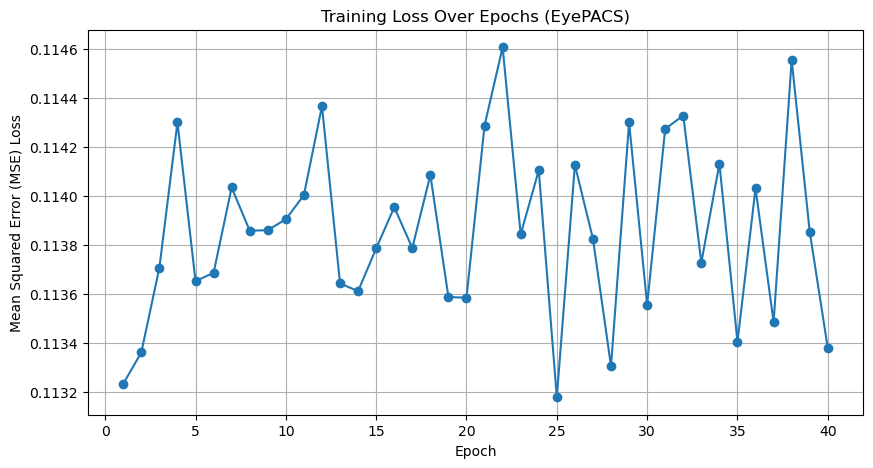

In [1]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Dataset Class for images (FLoRI21 and FIRE Dataset)
class RetinalImageDataset(Dataset):
    def __init__(self, image_dir, transform=None, image_exts=['.tif', '.png', '.jpeg', '.jpg']):
        self.image_dir = image_dir
        self.image_files = []
        for root, _, files in os.walk(image_dir):
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_exts):
                    self.image_files.append(os.path.join(root, file))
        self.transform = transform
        print(f"Found {len(self.image_files)} images in {self.image_dir}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        try:
            image = Image.open(img_path).convert("L")  # Open image in grayscale
        except FileNotFoundError:
            print(f"File not found: {img_path}")
            return None  # Handle missing files accordingly
        
        if self.transform:
            image = self.transform(image)
        return image

# Dataset Class for EyePACS (images only)
class EyePACSDataset(Dataset):
    def __init__(self, image_dir, transform=None, image_exts=['.ppm']):
        self.image_dir = image_dir
        self.image_files = []
        for root, _, files in os.walk(image_dir):
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_exts):
                    self.image_files.append(os.path.join(root, file))
        self.transform = transform
        print(f"Found {len(self.image_files)} images in {self.image_dir}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        try:
            image = Image.open(img_path).convert("L")  # Open image in grayscale
        except FileNotFoundError:
            print(f"File not found: {img_path}")
            return None  # Handle missing files accordingly
        
        if self.transform:
            image = self.transform(image)
        return image

# Data augmentation and transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor()
])

# Define the paths for all datasets
flori21_image_dir = 'FLoRI21_DataPort/'
fire_image_dir = 'FIRE/Images'
eyepacs_image_dir = 'EyePACS/'  # No labels file needed for EyePACS

# Load datasets
flori21_dataset = RetinalImageDataset(image_dir=flori21_image_dir, transform=transform)
fire_dataset = RetinalImageDataset(image_dir=fire_image_dir, transform=transform)
eyepacs_dataset = EyePACSDataset(image_dir=eyepacs_image_dir, transform=transform)

# Create data loaders
flori21_dataloader = DataLoader(flori21_dataset, batch_size=4, shuffle=True)
fire_dataloader = DataLoader(fire_dataset, batch_size=4, shuffle=True)
eyepacs_dataloader = DataLoader(eyepacs_dataset, batch_size=4, shuffle=True)

# Define the Neural Network Model
class RetinalImageModel(nn.Module):
    def __init__(self):
        super(RetinalImageModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Set up device for Apple Silicon MPS
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Set up model, loss function, optimizer, and scheduler
model = RetinalImageModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training function with loss logging and graph generation
def train_model(dataloader, model, criterion, optimizer, scheduler, num_epochs=5, dataset_name="dataset"):
    model.train()
    epoch_losses = []  # Store loss values for each epoch
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        
        for batch in dataloader:
            batch = [img for img in batch if img is not None]
            if len(batch) == 0:  # If all images in this batch were missing, skip this batch
                continue

            images = torch.stack(batch).to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, images)  # For unsupervised reconstruction tasks
            
            loss.backward()
            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(dataloader)
        epoch_losses.append(avg_epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")
    
    # Save the loss graph as an image
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), epoch_losses, marker='o')
    plt.title(f'Training Loss Over Epochs ({dataset_name})')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error (MSE) Loss')
    plt.grid(True)
    plt.savefig(f'{dataset_name}_loss_graph.png')
    plt.show()

# Training on each dataset and saving results
num_epochs = 40

print("\nTraining on FLoRI21 dataset:")
train_model(flori21_dataloader, model, criterion, optimizer, scheduler, num_epochs, "FLoRI21")

print("\nTraining on FIRE dataset:")
train_model(fire_dataloader, model, criterion, optimizer, scheduler, num_epochs, "FIRE")

print("\nTraining on EyePACS dataset:")
train_model(eyepacs_dataloader, model, criterion, optimizer, scheduler, num_epochs, "EyePACS")
